<a href="https://colab.research.google.com/github/WajeehaTahir/braille-to-text/blob/main/Braille.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import cv2
import numpy as np
import copy
from google.colab.patches import cv2_imshow

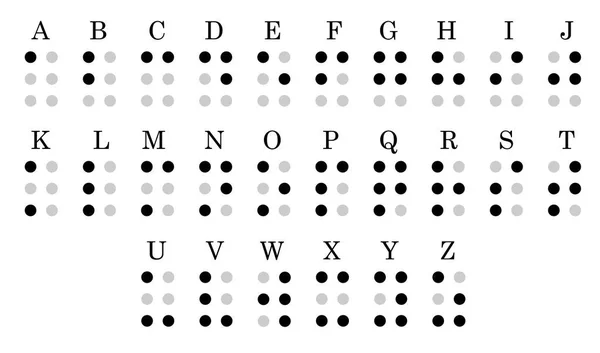

In [ ]:
decode_pattern = cv2.imread("decode pattern.jpg", 0)
cv2_imshow(decode_pattern)
#cv2.waitKey()

In [ ]:
def parseDecodePattern(image):
    kernel = np.ones((7, 7), np.uint8)
    image = cv2.dilate(image, kernel, iterations=1)     #dilating to remove text
    image = cv2.erode(image, kernel, iterations=4)

    kernel[:,:] = 0
    kernel[:, 3] = 1
    image = cv2.erode(image, kernel, iterations=4)  #eroding vertically to ensure dots connect

    cv2_imshow(image)
    #cv2.waitKey()

    return image

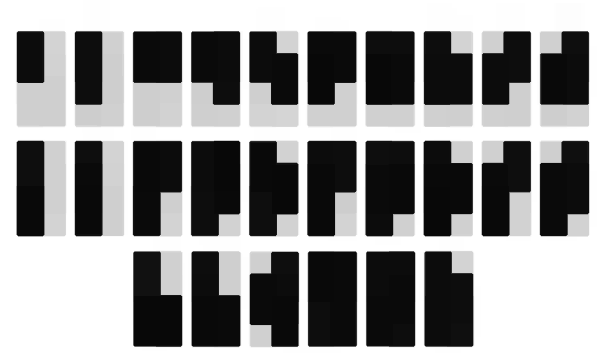

In [ ]:
connected_decode_pattern = parseDecodePattern(decode_pattern)   #join dots

In [ ]:
def getNeighbours(labels, pixel):
    return [labels[pixel[0], pixel[1] - 1], labels[pixel[0] - 1, pixel[1] - 1], labels[pixel[0] - 1, pixel[1]], labels[pixel[0] - 1, pixel[1] + 1]] #left, top left, top, top right neighbors

def cca(image, v):
    _, image = cv2.threshold(image, 127, 255, cv2.THRESH_BINARY)
    image = cv2.copyMakeBorder(image, 1, 1, 1, 1, cv2.BORDER_CONSTANT, value=255)   #add white border
    labels = np.zeros((image.shape[0], image.shape[1]), dtype=np.int32)  #initialize labels to zero
    label = 0   #current label
    equivalence_table = {}

    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            if image[i, j] in v:
                neighbours = getNeighbours(labels, [i, j])
                if neighbours.count(0) == len(neighbours):  #if label of every neighbor is zero, no neighbor is in v set
                    label += 1
                    labels[i, j] = label    #assign new label
                else:
                    labels[i, j] = min([x for x in neighbours if x != 0])   #set label to minimum of non zero neighbor labels
                    for x in neighbours:
                       if x!= 0 and x!= labels[i, j]:   #for every other neighbor label
                           if labels[i, j] in equivalence_table.keys():
                               equivalence_table[x] = equivalence_table[labels[i, j]]   #if label is already in equivalence table, assign pointed value
                           else:
                                equivalence_table[x] = labels[i, j] #create new equivalence

    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            if labels[i, j] in equivalence_table.keys():
                labels[i, j] = equivalence_table[labels[i, j]]  #replace values from equivalence table

    object_count = label - len(equivalence_table)   #number of objects is maximum label value minus number of collisions

    colors = np.random.randint(0, 255, size=(np.max(labels)+1, 3), dtype=np.uint8)
    color_image = colors[labels]
    cv2_imshow(color_image)
    #cv2.waitKey()

    return object_count, labels[1:labels.shape[0] - 1, 1:labels.shape[1] - 1]   #remove white padding from labels array

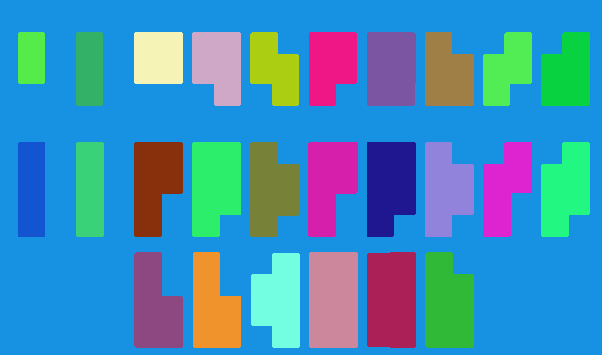

In [ ]:
_, labels_decode_pattern = cca(connected_decode_pattern, [0])   #create labels map

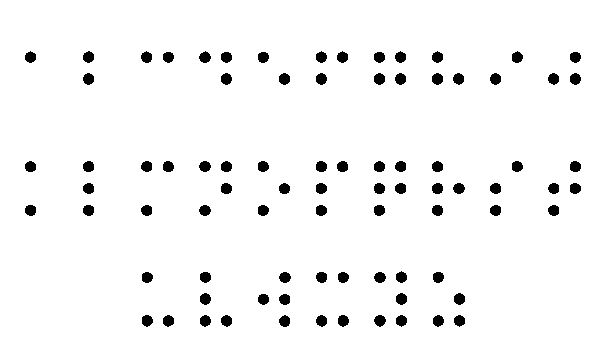

In [ ]:
_, decode_pattern = cv2.threshold(decode_pattern, 100, 255, cv2.THRESH_BINARY)  #remove grey dots
decode_pattern = cv2.morphologyEx(decode_pattern, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5)))  #remove text
cv2_imshow(decode_pattern)
#cv2.waitKey()

In [ ]:
def cropImage(labels, image, word_labels, space_flag):
    label_numbers = []  #list of label numbers assigned to objects

    #to get label numbers in the same sequence as they appear in the label map, find one row that contains label numbers of every object for every row of objects in the image
    idx = np.argwhere(np.all(labels[..., :] == 0, axis=0))  #delete all zero columns
    temp = np.delete(labels, idx, axis=1)
    temp = temp[~np.all(labels == 0, axis=1)]   #delete all zero rows
    temp = np.unique(temp, axis=0)  #delete all repeating rows
    starting_labels, count =  np.unique([next((elem for elem in row if elem != 0), 0) for row in temp], return_counts=True) #if row starts with a different non zero label, it is a row of new objects
    to_remove = starting_labels[count < 3] #to remove starting values with very low frequency as they may not give the true sequence of objects
    for x in to_remove:
         starting_labels = np.delete(starting_labels, np.where(starting_labels == x))

    labels_array = []

    for x in starting_labels:
        temp1 = temp[np.any(temp == x, axis=1)]     #get all rows with the same starting element
        unique_elements = [len(np.unique(row)) for row in temp1] #get the row with the most number of unique elements, i.e. the most number of object labels
        labels_array.append(temp1[unique_elements.index(max(unique_elements))]) #append the row to the label_numbers list

    for row in labels_array:
        for val in row:
            if val != 0 and val not in label_numbers:
                label_numbers.append(val)   #remove repetition and zeros from labels_array

    images = []

    if space_flag:
        space_offset = max(np.unique(np.delete(labels_array[0], np.where(labels_array[0] == 0))))   #set offset equal to the width of the widest character

    for label in label_numbers:
        left, right = getStartandEnd(label, labels) #get the left, right, bottom, top edges
        top, bottom = getStartandEnd(label, labels.transpose())
        images.append(image[top:bottom + 1, left:right + 1])    #extract image with those edges

        if space_flag:  #if spaces have to be inserted
            if right + space_offset > word_labels.shape[1]: #if the word is last in the row
                images.append(" ")
            elif word_labels[(bottom + top) // 2, right + space_offset] == 0:  #if area to the right of the image is zero in the words labels map
                images.append(" ")

    for i in images:
        if i != " ":
            cv2_imshow(np.uint8(i))
    #        cv2.waitKey()

    return images

def getStartandEnd(label, labels):
    start = labels.shape[1] - 1     #set start to the end of the image
    end = 0 #end to the start

    for i in range(labels.shape[0]):    #bracket the starting and ending points of the label
        if label in labels[i]:  #check each row and update values
            if labels[i].tolist().index(label) < start:
                start = labels[i].tolist().index(label)
            if len(labels[i]) - 1 - labels[i][::-1].tolist().index(label) > end:
                end = len(labels[i]) - 1 - labels[i][::-1].tolist().index(label)

    return start, end

<ipython-input-47-cd76354a9385>:43: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if i != " ":


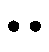

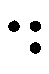

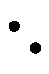

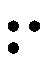

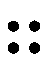

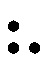

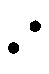

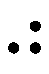

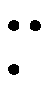

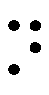

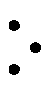

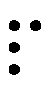

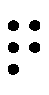

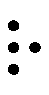

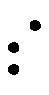

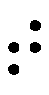

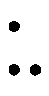

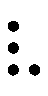

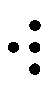

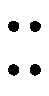

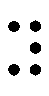

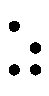

In [ ]:
decode_key = cropImage(labels_decode_pattern, decode_pattern, [0], False)   #get list of individual braille characters

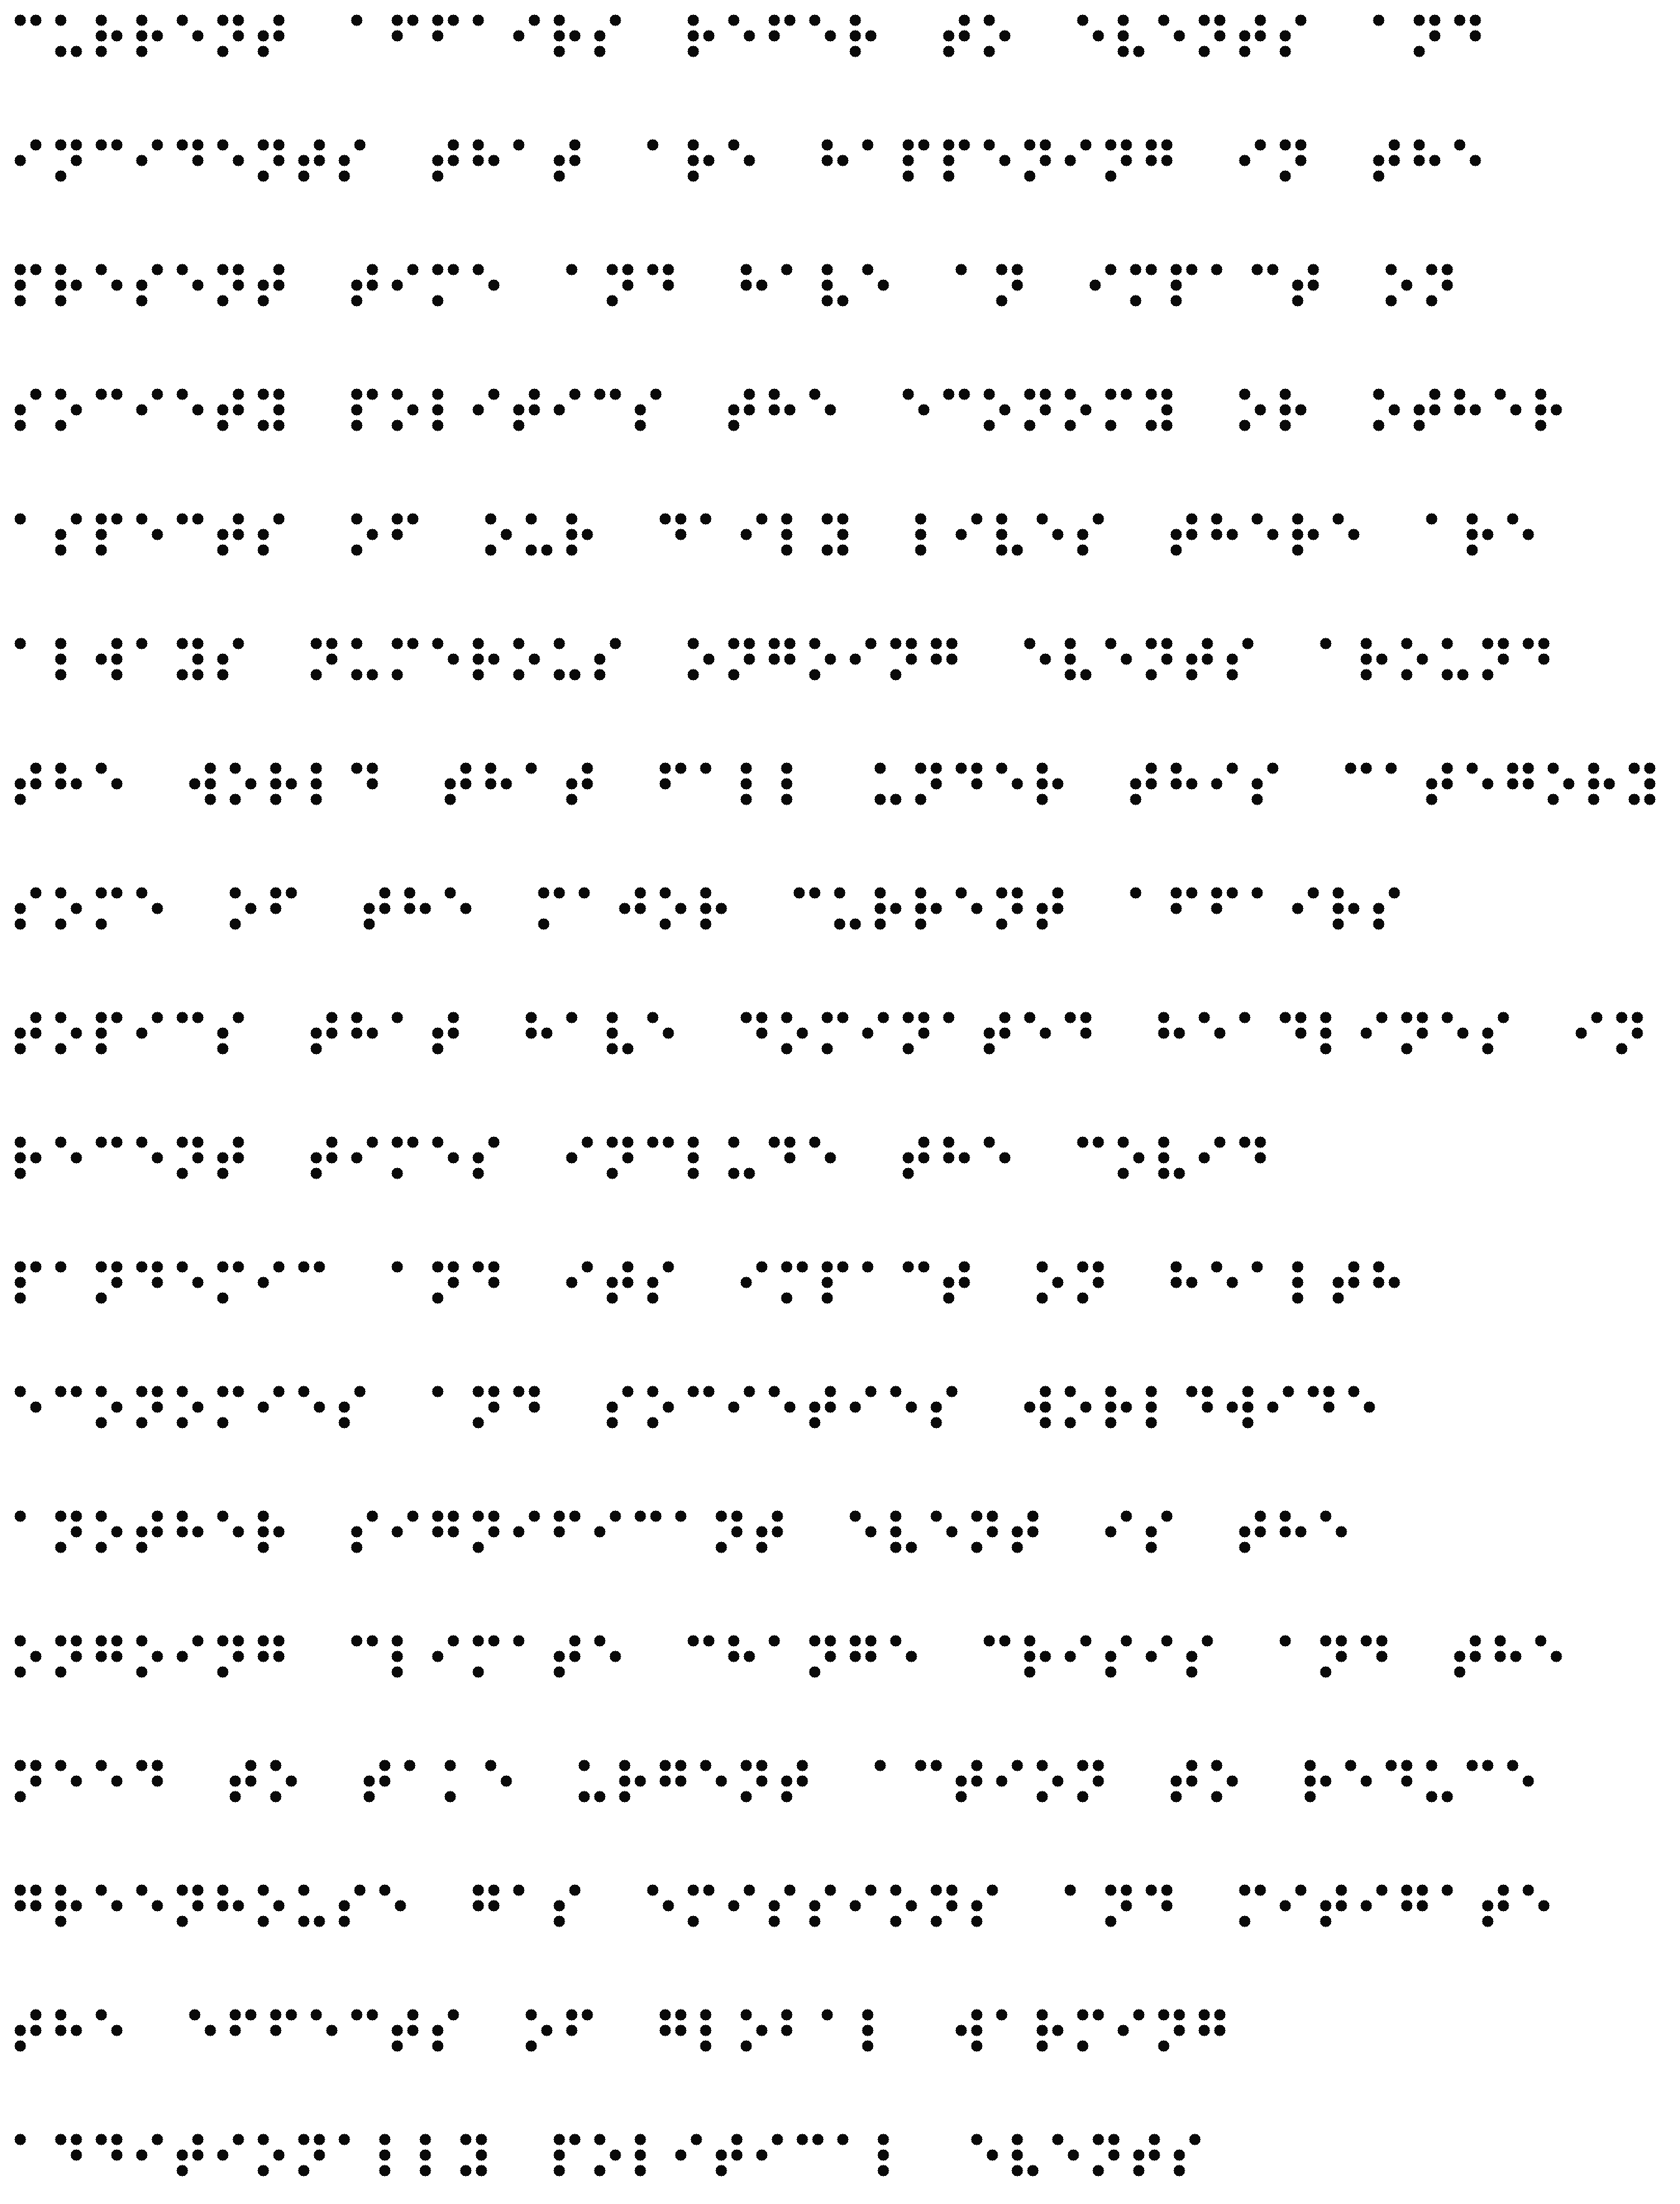

In [ ]:
braille = cv2.imread("Braille.png", 0)
cv2_imshow(braille)
#cv2.waitKey()

In [ ]:
def parseBraille(image):
    kernel = np.zeros((13, 13), np.uint8)
    kernel[:, 6] = 1
    image = cv2.dilate(image, kernel, iterations=1) #dilating to maintain shape
    image = cv2.erode(image, kernel, iterations=4)

    kernel[:, 6] = 0
    kernel[6, 2:10] = 1
    image = cv2.dilate(image, kernel, iterations=1)
    image = cv2.erode(image, kernel, iterations=4)  #vertical erosion

    cv2_imshow(image)
    #cv2.waitKey()

    return image

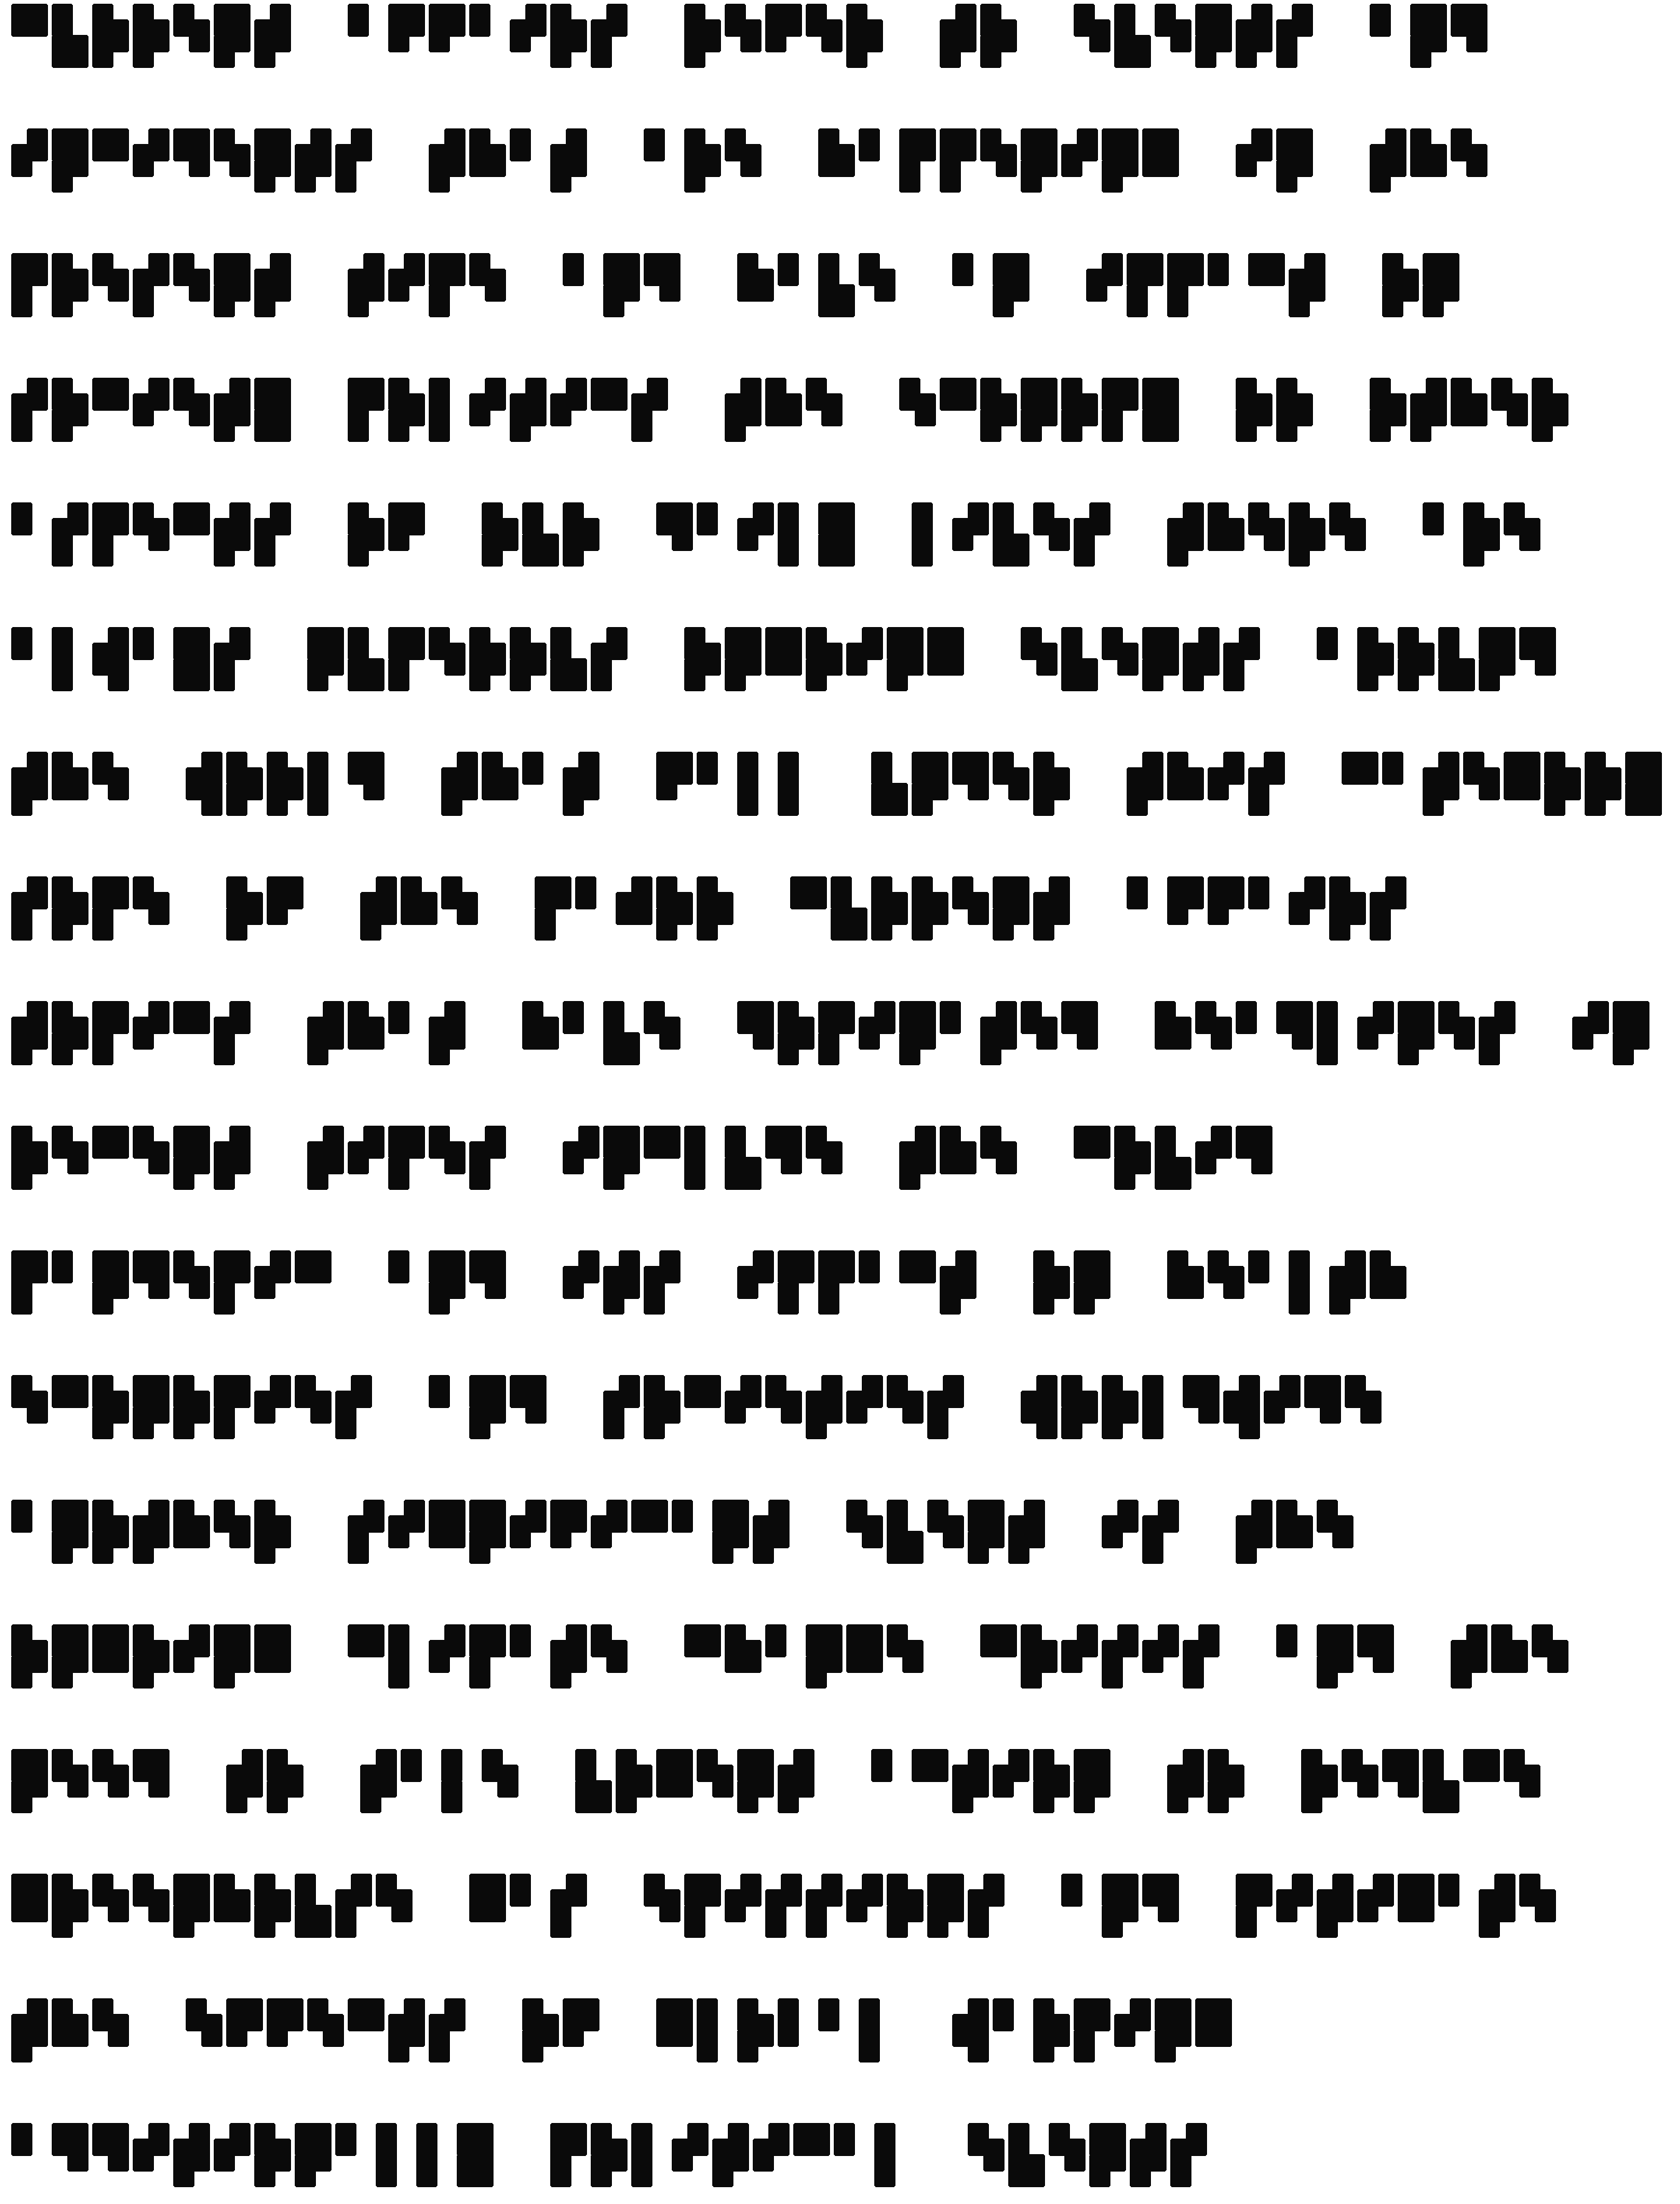

In [ ]:
connected_braille = parseBraille(braille)   #join dots

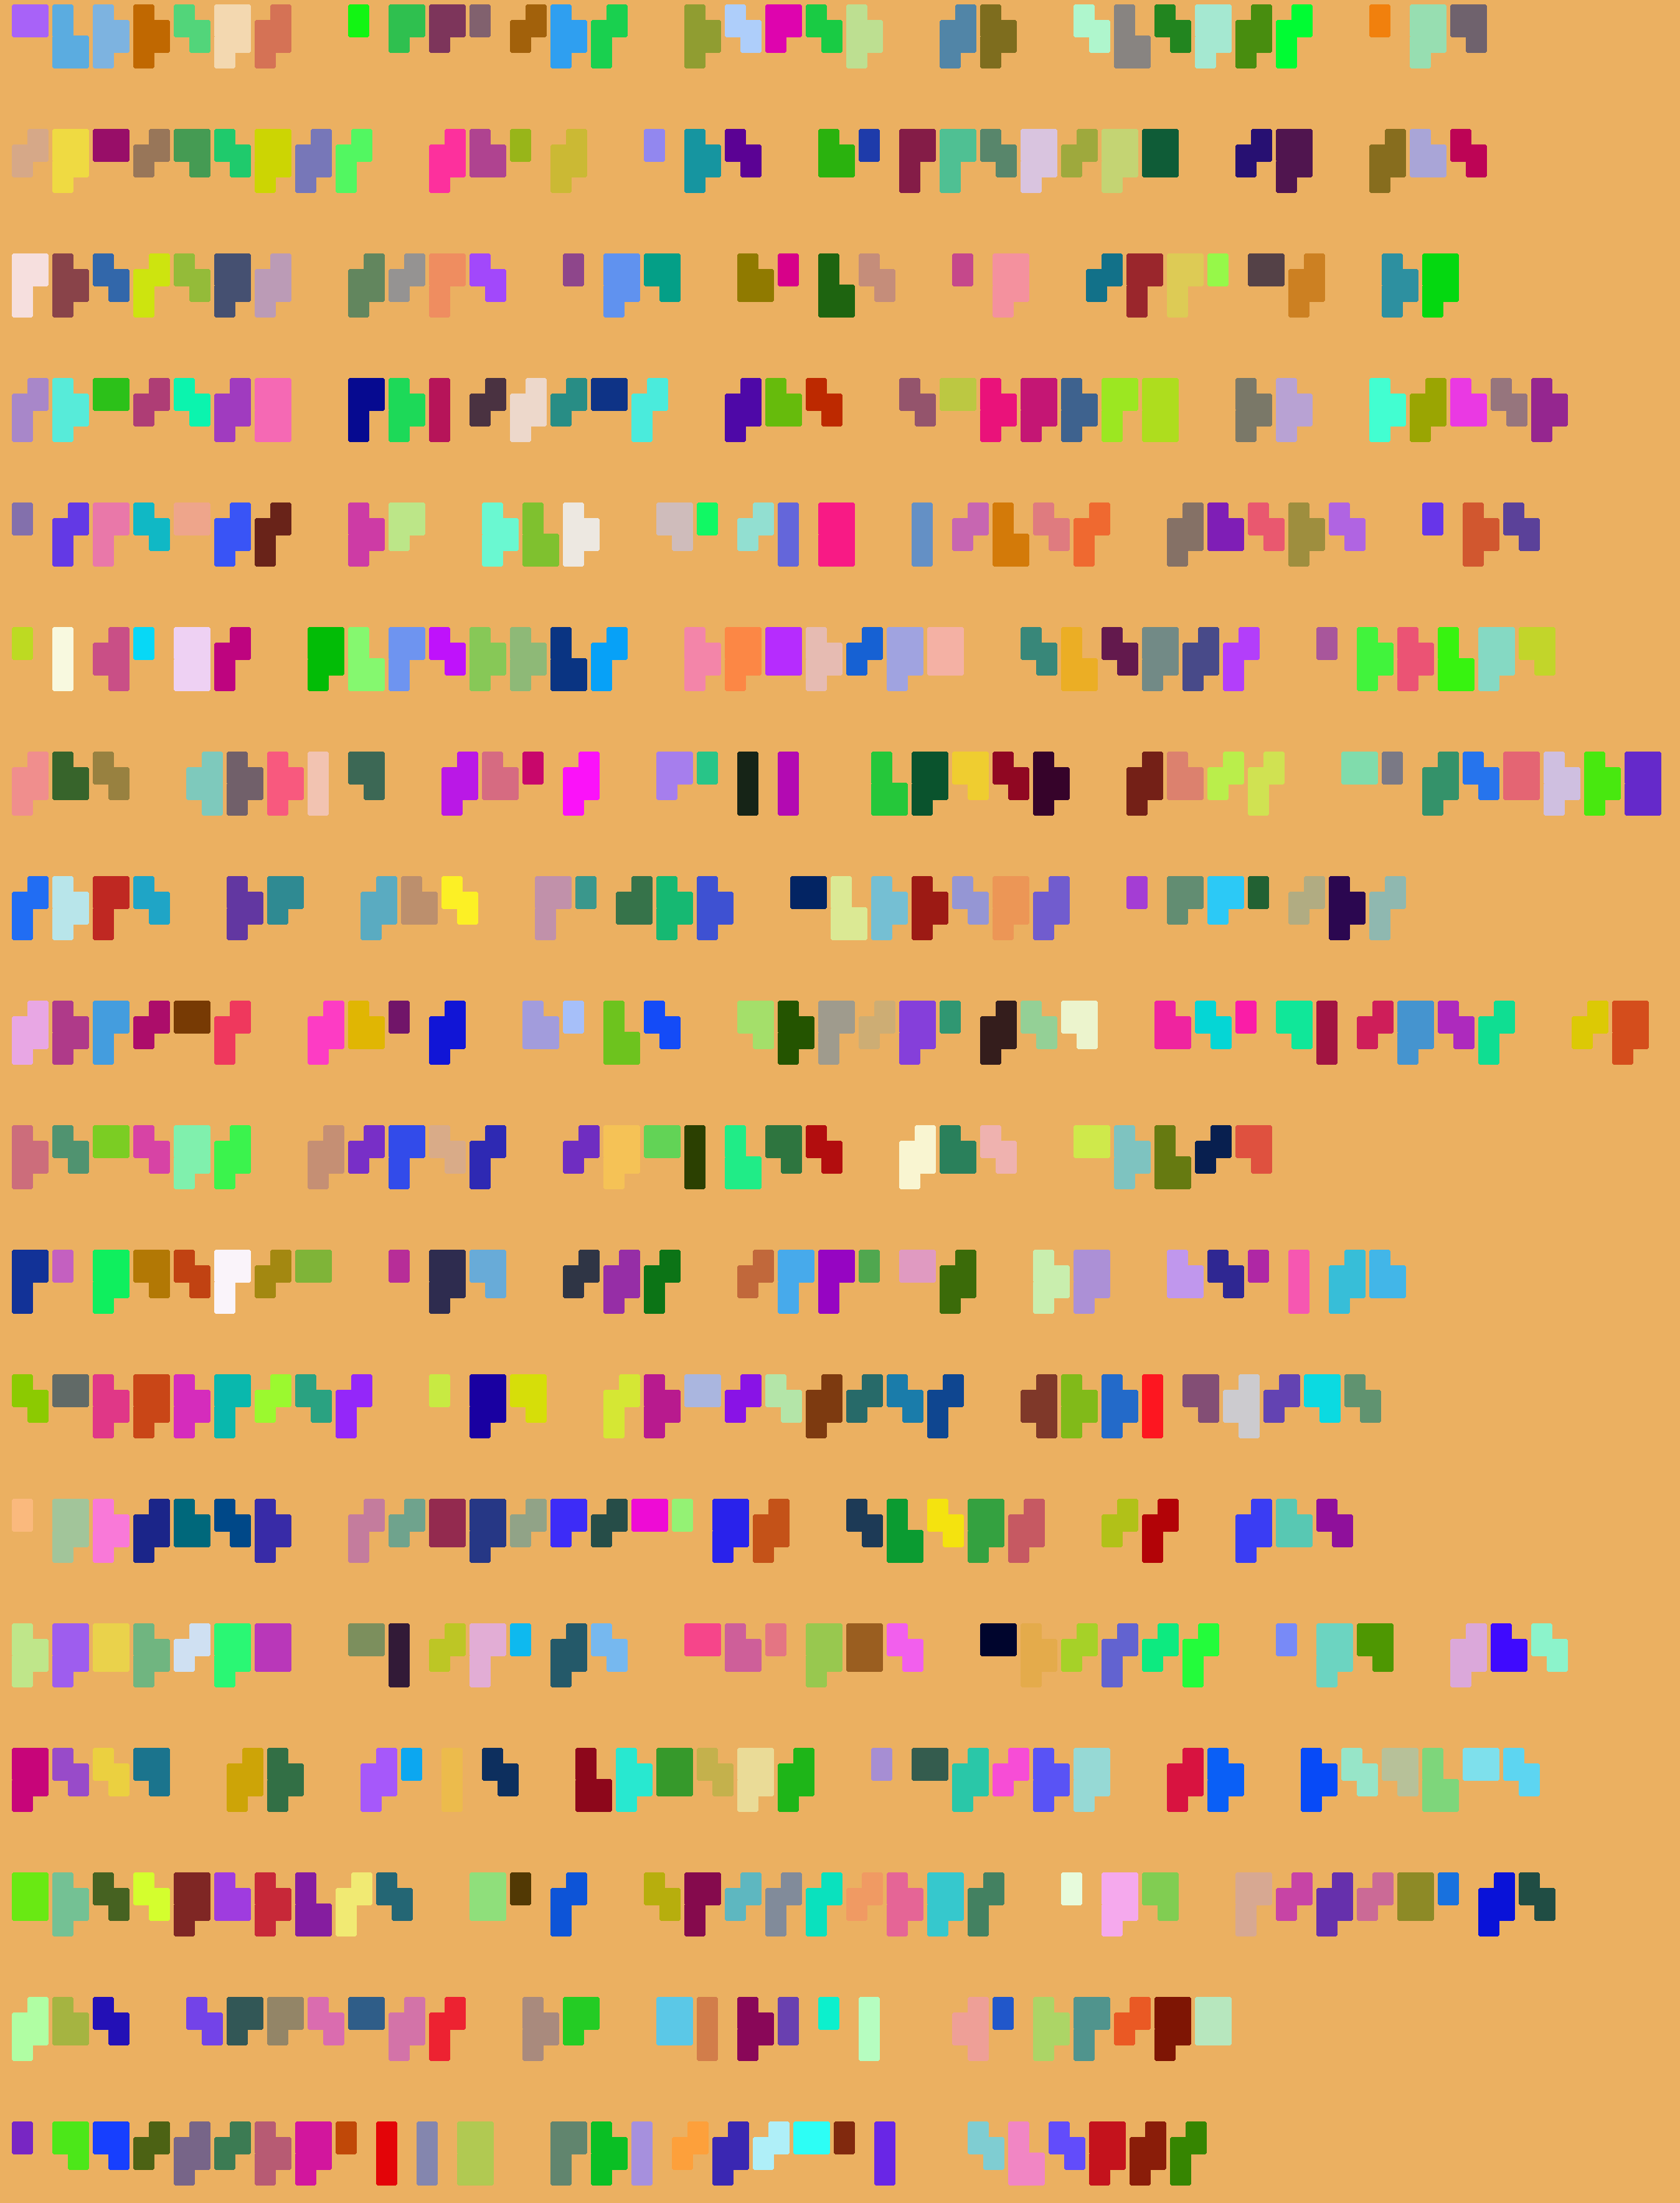

In [ ]:
_, labels_braille = cca(connected_braille, [0]) #create labels map

In [ ]:
def joinCharacters(image):
    kernel = np.ones((9, 9), np.uint8)
    image = cv2.erode(image, kernel, iterations=5)

    kernel[:, 7] = 0
    kernel[4, :] = 1
    image = cv2.erode(image, kernel, iterations=2)  #ensure characters join by maximixing horizontal erosion

    cv2_imshow(image)
    #cv2.waitKey()

    return image

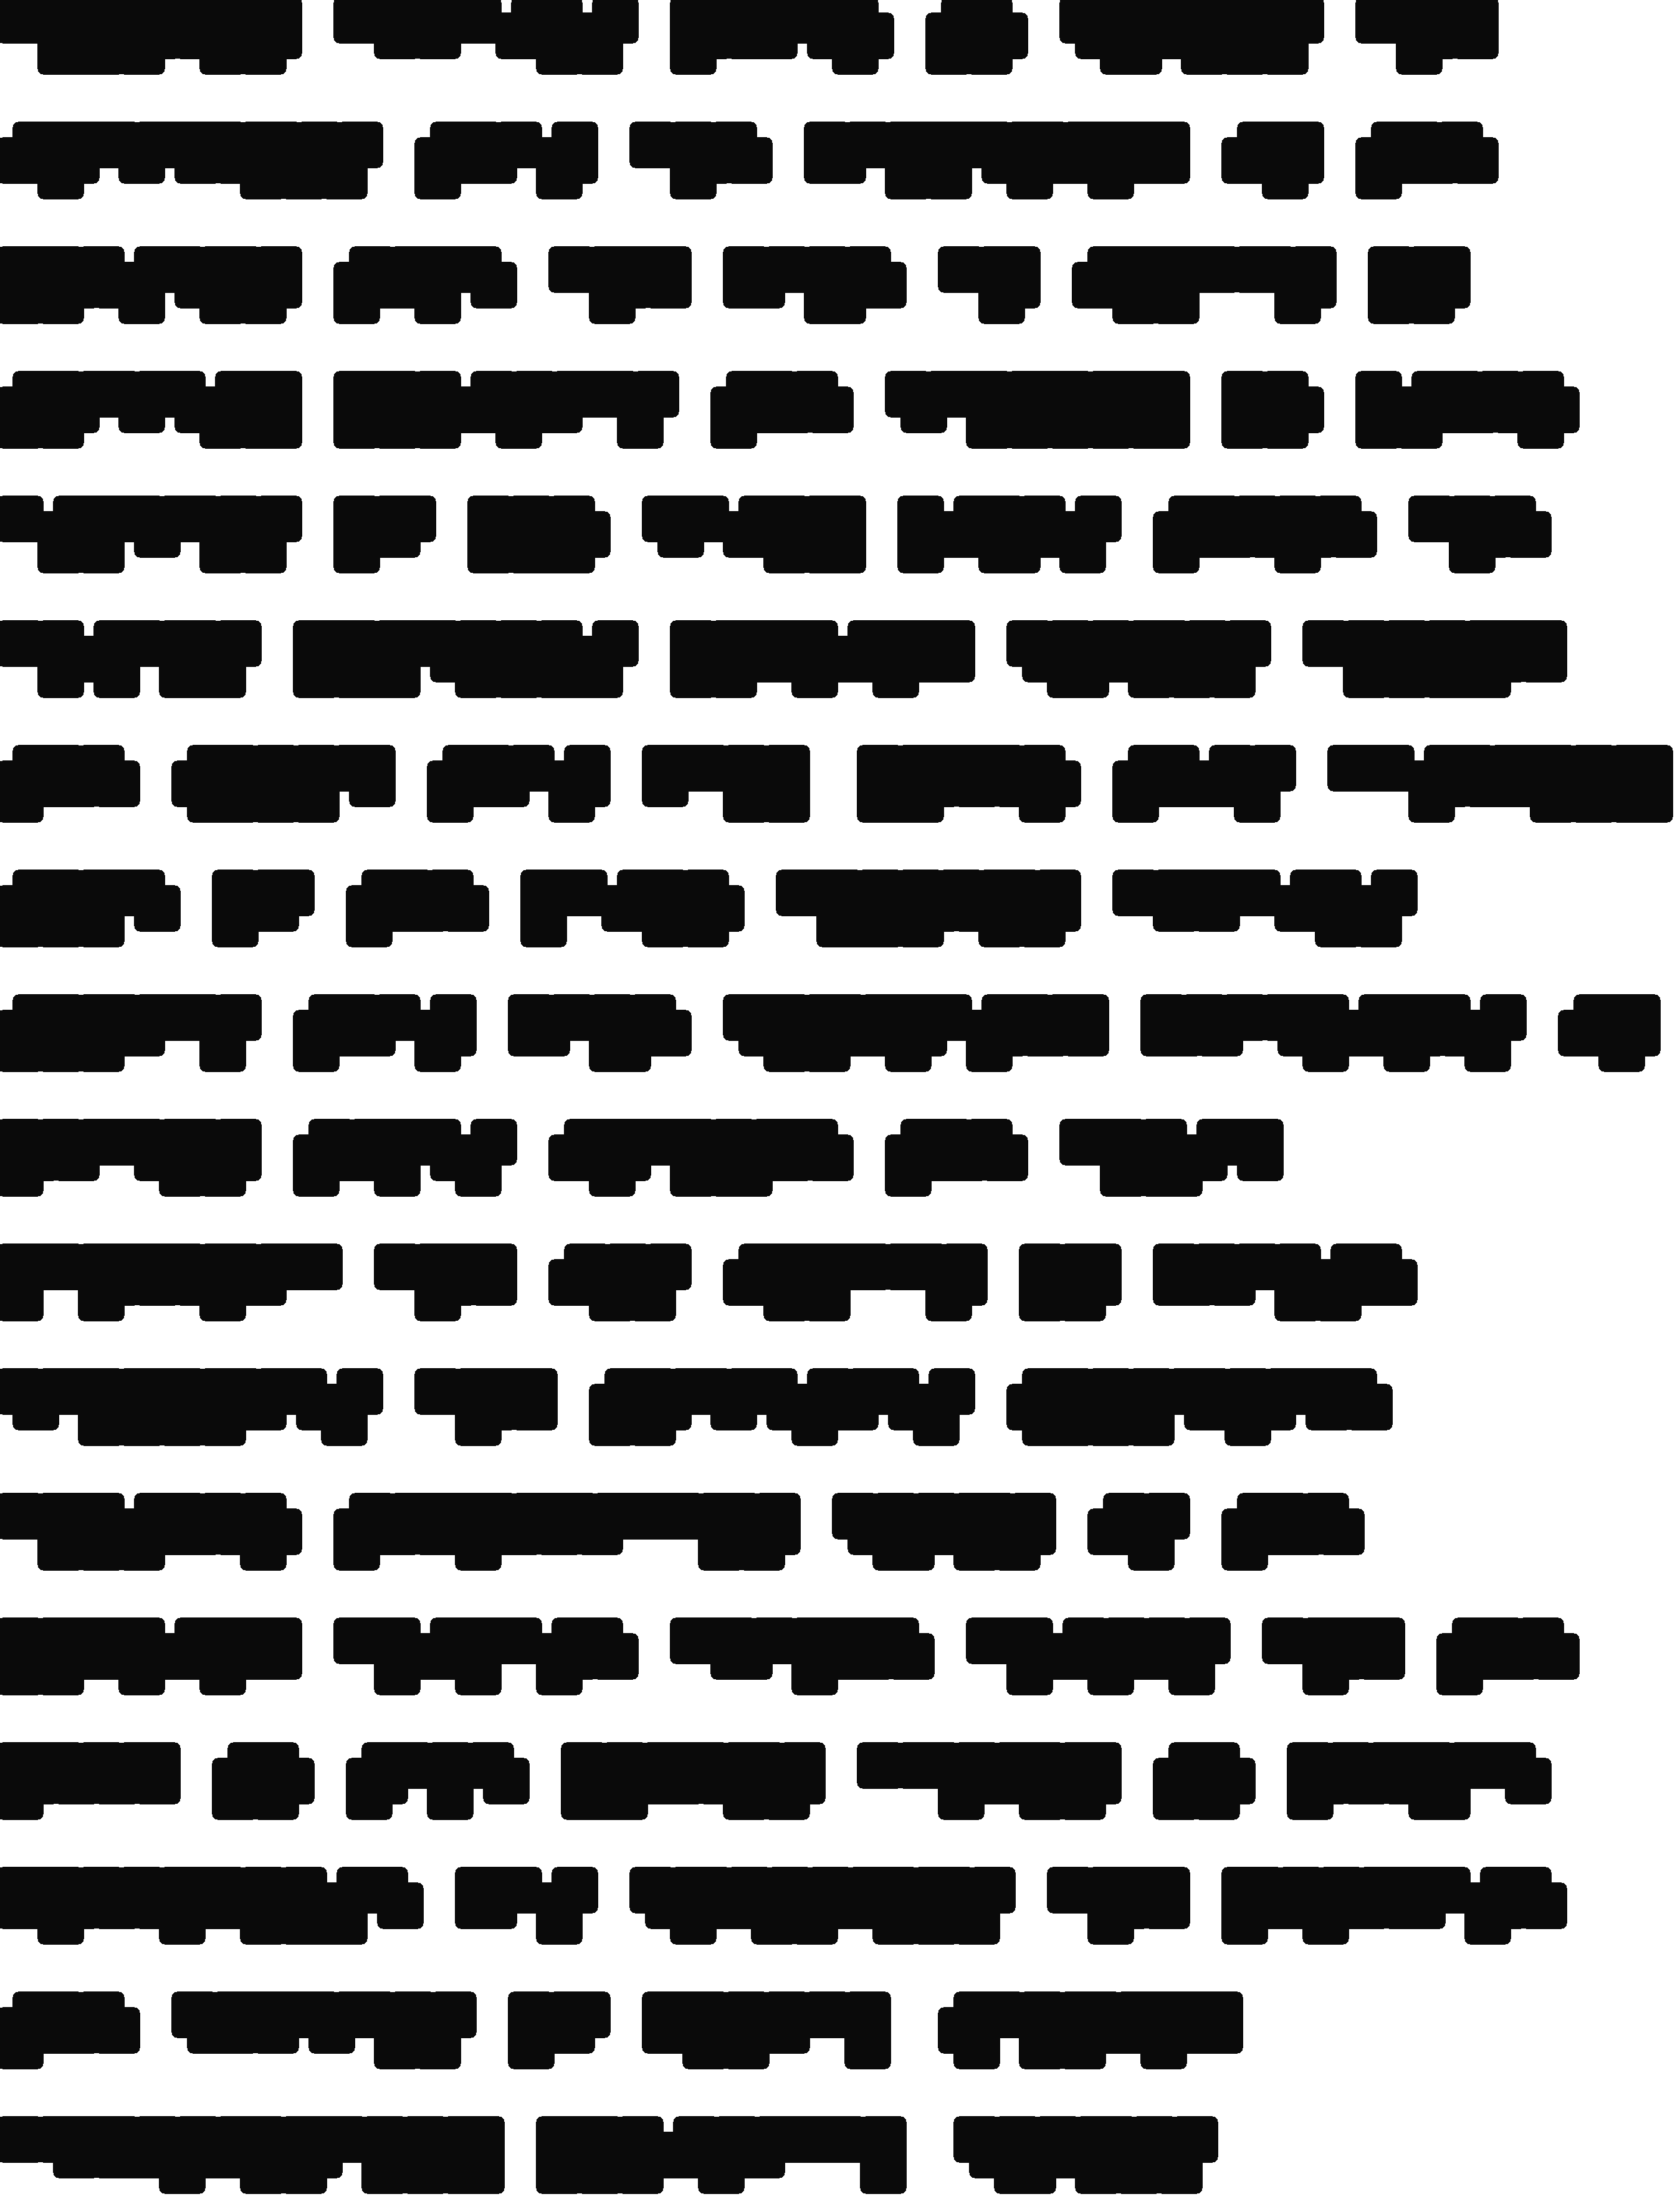

In [ ]:
braille_words = joinCharacters(braille) #join characters to highlight words

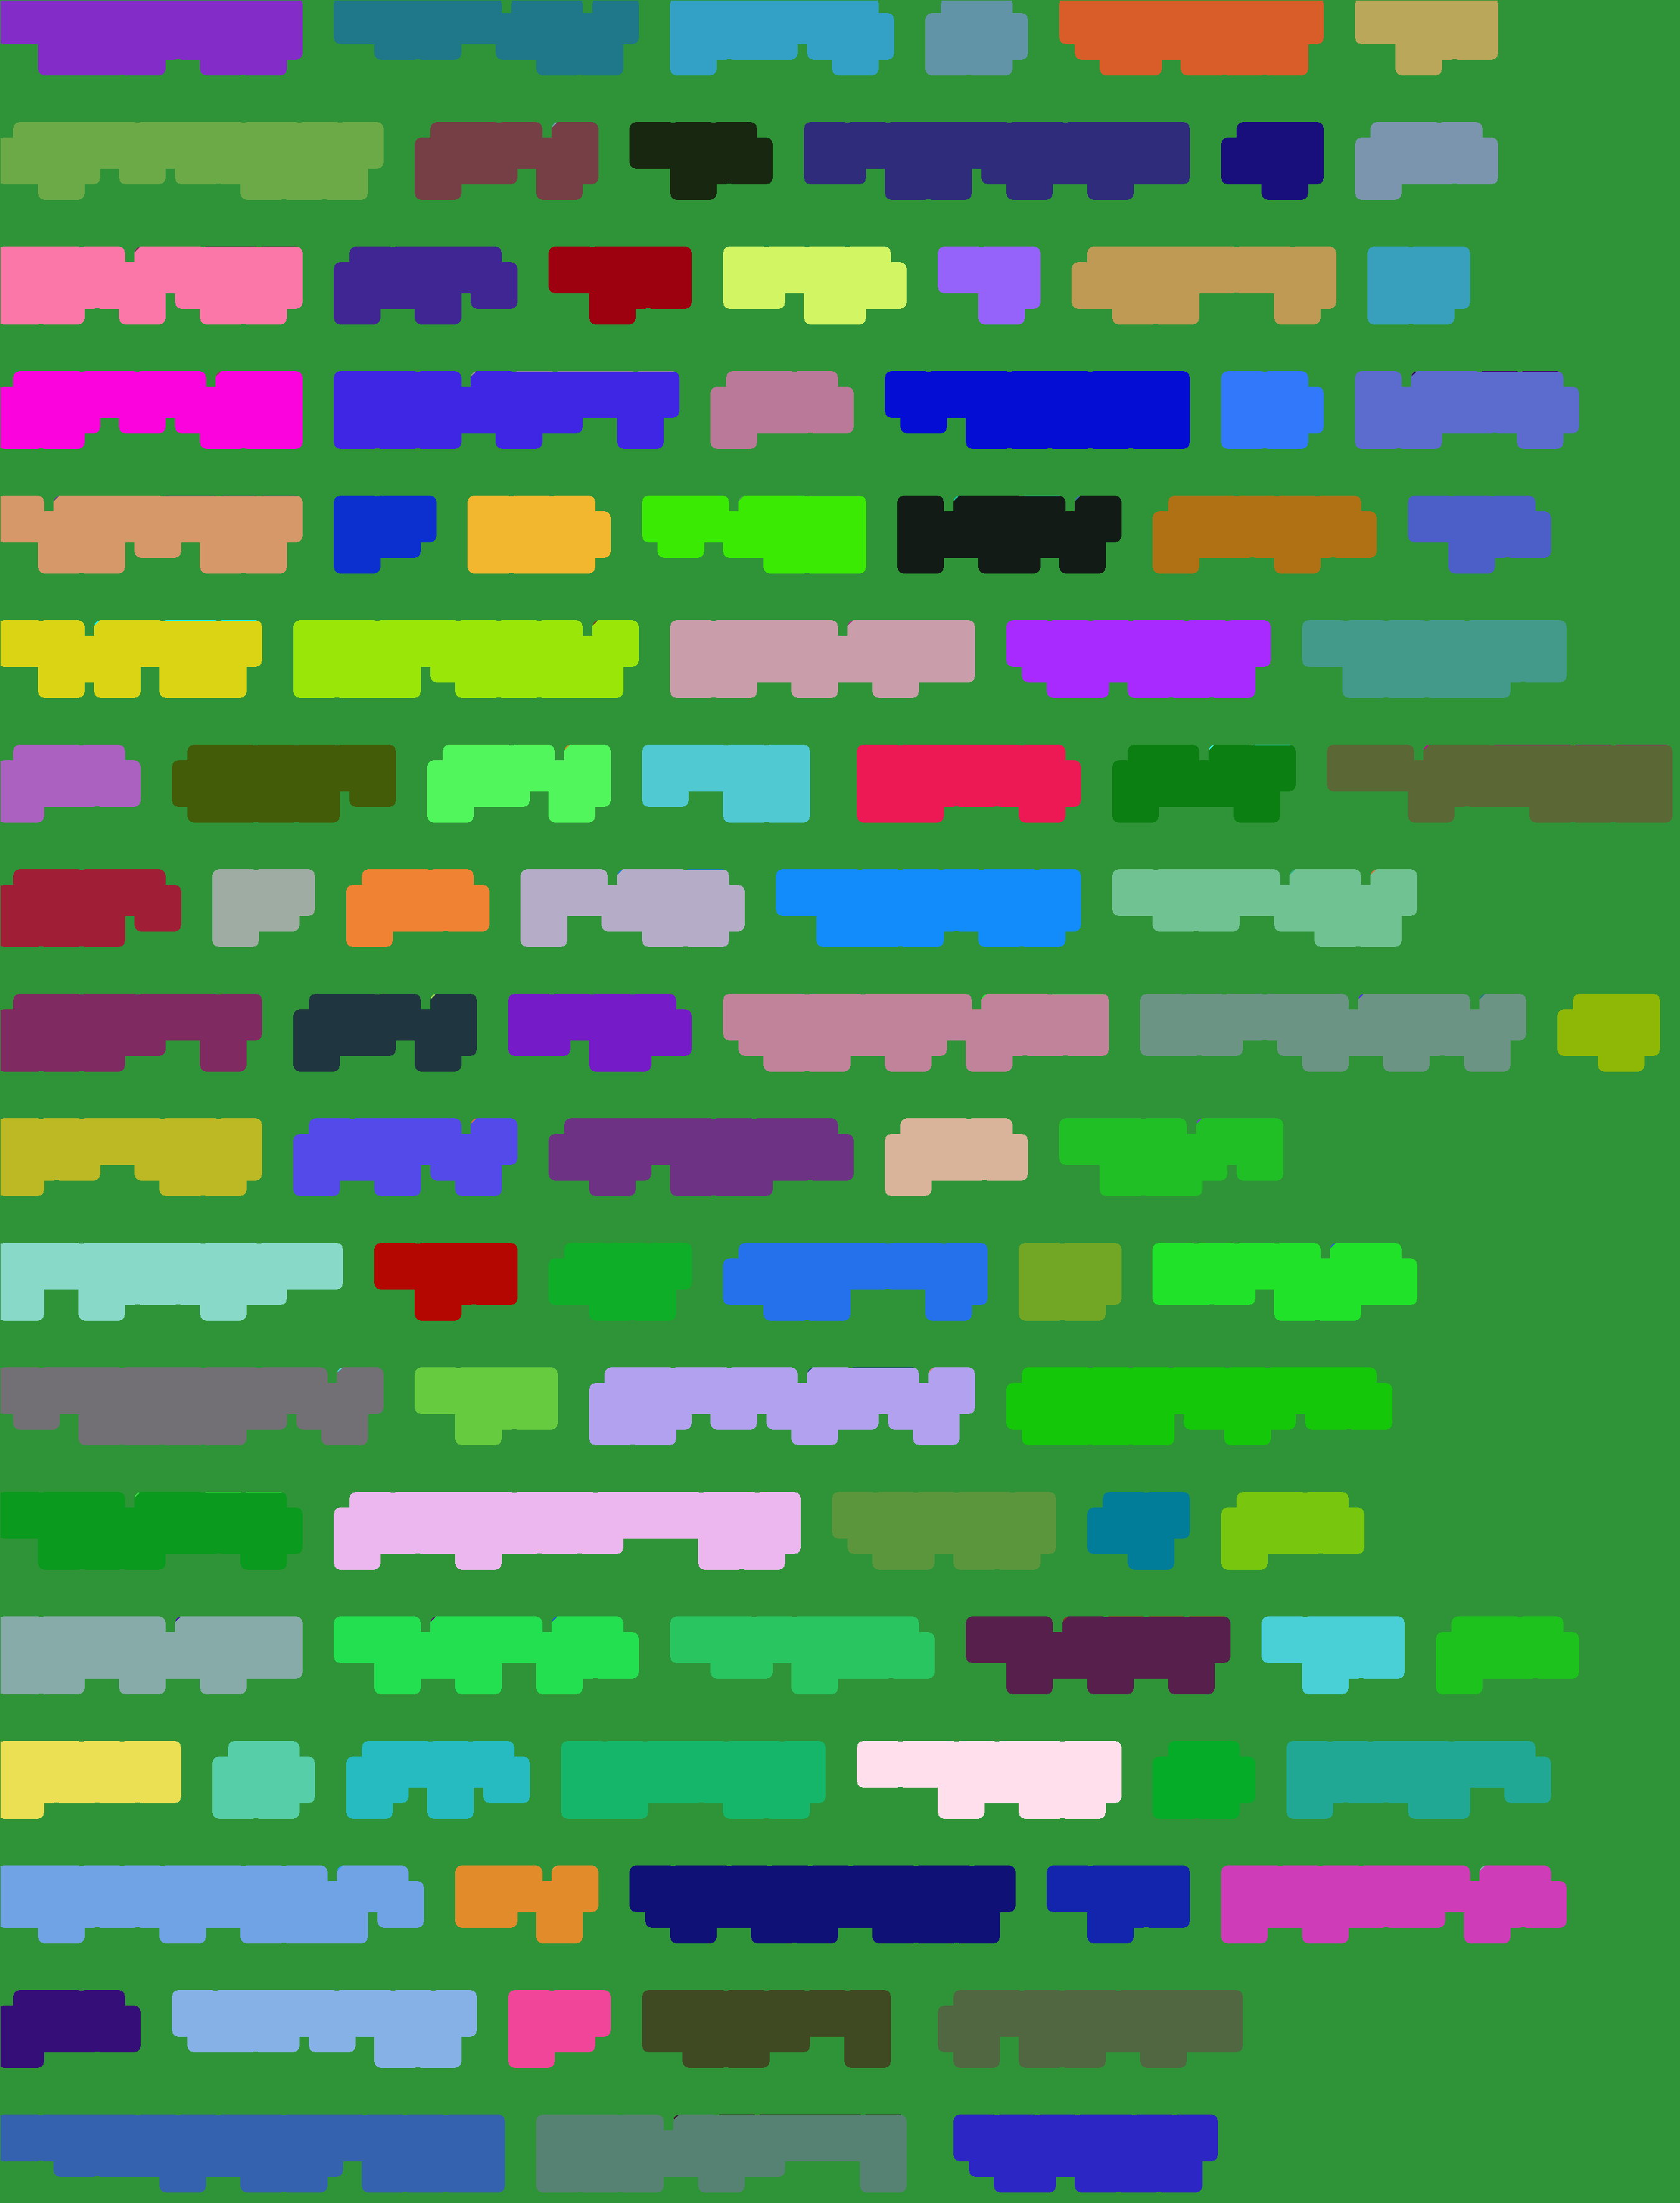

In [ ]:
_, labels_braille_words = cca(braille_words, [0])   #get labels map for words

In [ ]:
def cropImage(labels, image, word_labels, space_flag):
    label_numbers = []  #list of label numbers assigned to objects

    #to get label numbers in the same sequence as they appear in the label map, find one row that contains label numbers of every object for every row of objects in the image
    idx = np.argwhere(np.all(labels[..., :] == 0, axis=0))  #delete all zero columns
    temp = np.delete(labels, idx, axis=1)
    temp = temp[~np.all(labels == 0, axis=1)]   #delete all zero rows
    temp = np.unique(temp, axis=0)  #delete all repeating rows
    starting_labels, count =  np.unique([next((elem for elem in row if elem != 0), 0) for row in temp], return_counts=True) #if row starts with a different non zero label, it is a row of new objects
    to_remove = starting_labels[count < 3] #to remove starting values with very low frequency as they may not give the true sequence of objects
    for x in to_remove:
         starting_labels = np.delete(starting_labels, np.where(starting_labels == x))

    labels_array = []

    for x in starting_labels:
        temp1 = temp[np.any(temp == x, axis=1)]     #get all rows with the same starting element
        unique_elements = [len(np.unique(row)) for row in temp1] #get the row with the most number of unique elements, i.e. the most number of object labels
        labels_array.append(temp1[unique_elements.index(max(unique_elements))]) #append the row to the label_numbers list

    for row in labels_array:
        for val in row:
            if val != 0 and val not in label_numbers:
                label_numbers.append(val)   #remove repetition and zeros from labels_array

    images = []

    if space_flag:
        space_offset = max(np.unique(np.delete(labels_array[0], np.where(labels_array[0] == 0))))   #set offset equal to the width of the widest character

    for label in label_numbers:
        left, right = getStartandEnd(label, labels) #get the left, right, bottom, top edges
        top, bottom = getStartandEnd(label, labels.transpose())
        images.append(image[top:bottom + 1, left:right + 1])    #extract image with those edges
        if space_flag:  #if spaces have to be inserted
            if right + space_offset >= word_labels.shape[1]: #if the word is last in the row
                images.append(" ")
            elif word_labels[(bottom + top) // 2, right + space_offset] == 0:  #if area to the right of the image is zero in the words labels map
                images.append(" ")

    for i in images:
        if i != " ":
            cv2_imshow(np.uint8(i))
    #        cv2.waitKey()

    return images

def getStartandEnd(label, labels):
    start = labels.shape[1] - 1     #set start to the end of the image
    end = 0 #end to the start

    for i in range(labels.shape[0]):    #bracket the starting and ending points of the label
        if label in labels[i]:  #check each row and update values
            if labels[i].tolist().index(label) < start:
                start = labels[i].tolist().index(label)
            if len(labels[i]) - 1 - labels[i][::-1].tolist().index(label) > end:
                end = len(labels[i]) - 1 - labels[i][::-1].tolist().index(label)

    return start, end

<ipython-input-58-d9213952c5ae>:42: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if i != " ":


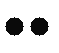

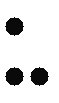

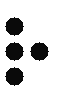

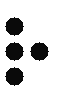

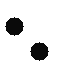

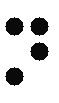

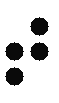

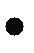

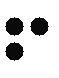

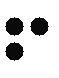

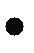

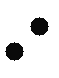

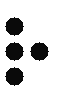

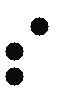

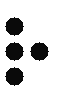

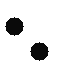

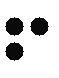

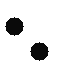

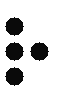

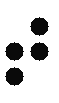

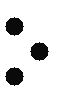

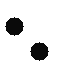

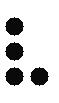

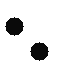

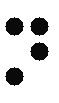

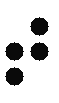

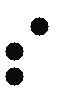

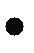

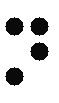

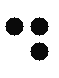

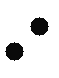

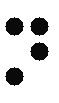

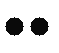

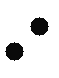

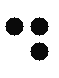

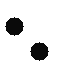

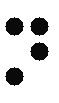

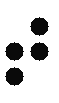

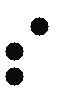

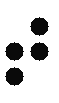

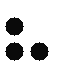

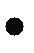

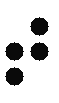

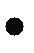

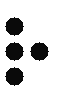

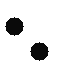

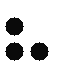

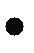

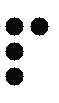

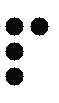

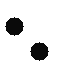

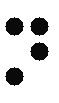

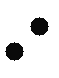

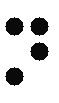

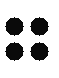

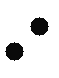

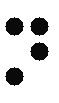

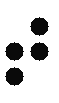

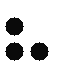

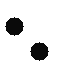

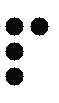

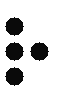

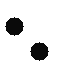

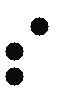

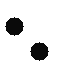

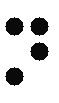

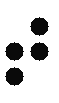

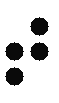

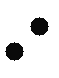

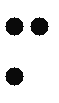

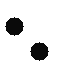

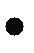

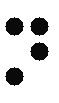

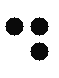

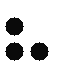

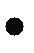

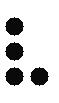

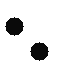

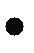

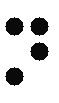

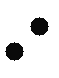

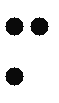

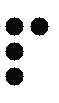

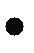

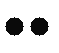

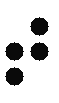

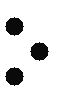

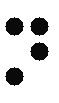

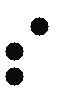

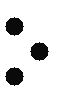

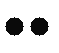

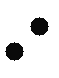

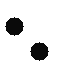

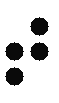

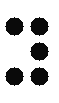

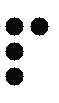

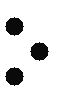

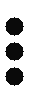

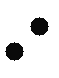

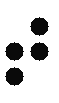

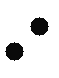

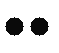

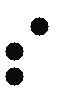

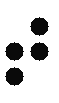

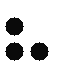

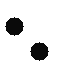

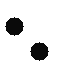

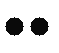

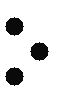

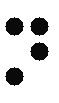

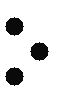

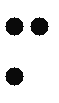

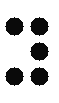

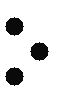

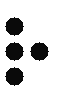

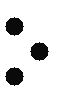

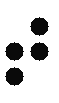

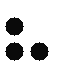

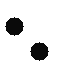

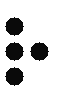

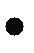

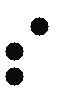

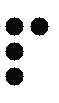

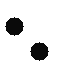

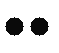

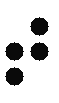

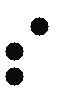

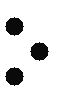

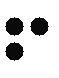

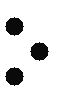

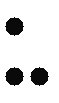

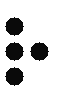

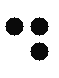

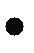

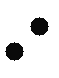

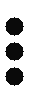

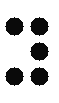

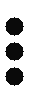

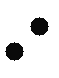

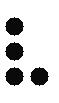

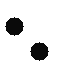

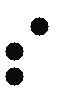

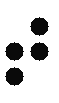

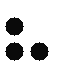

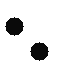

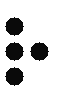

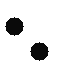

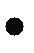

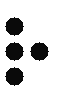

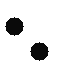

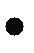

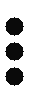

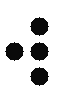

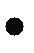

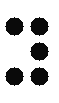

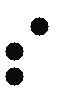

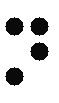

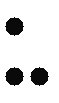

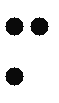

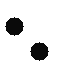

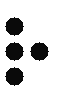

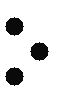

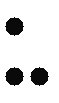

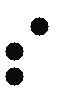

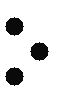

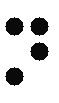

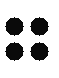

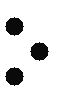

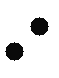

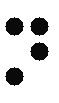

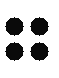

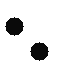

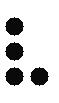

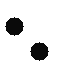

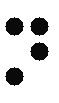

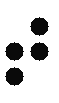

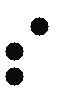

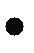

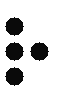

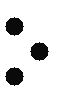

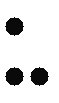

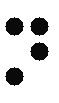

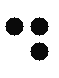

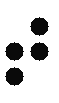

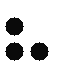

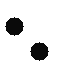

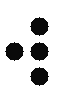

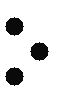

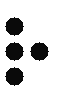

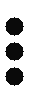

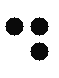

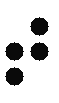

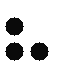

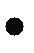

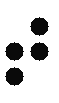

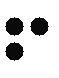

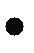

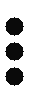

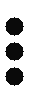

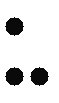

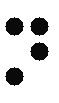

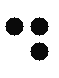

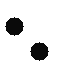

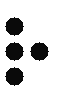

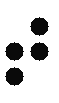

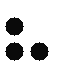

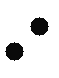

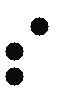

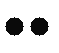

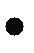

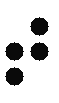

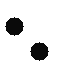

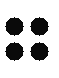

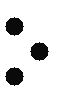

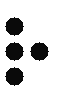

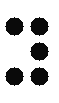

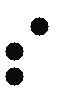

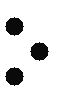

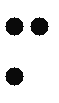

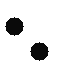

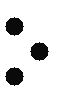

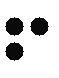

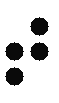

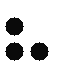

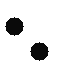

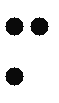

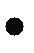

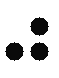

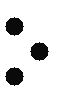

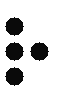

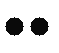

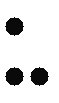

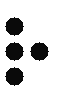

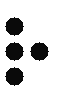

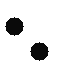

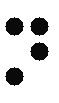

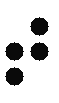

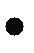

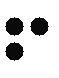

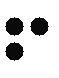

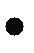

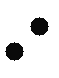

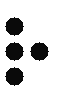

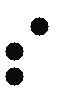

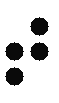

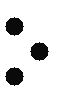

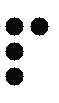

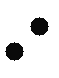

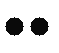

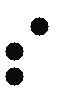

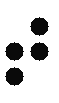

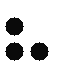

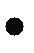

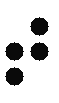

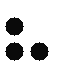

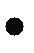

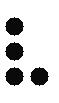

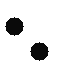

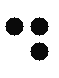

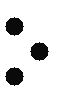

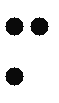

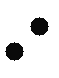

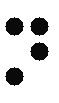

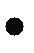

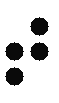

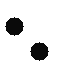

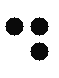

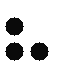

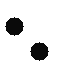

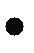

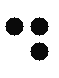

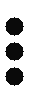

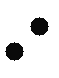

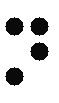

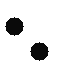

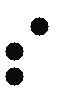

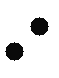

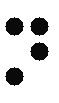

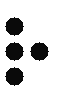

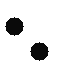

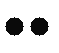

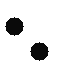

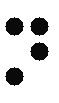

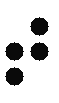

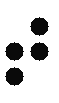

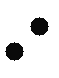

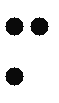

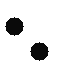

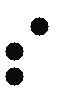

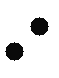

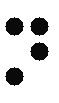

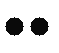

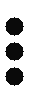

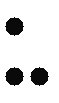

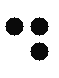

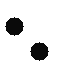

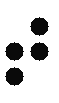

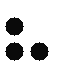

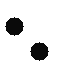

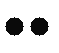

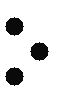

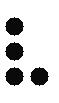

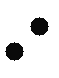

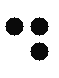

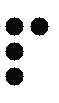

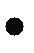

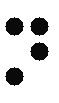

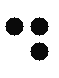

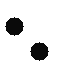

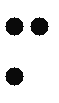

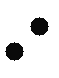

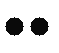

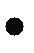

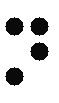

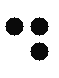

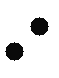

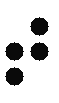

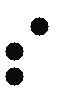

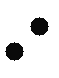

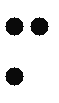

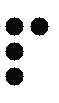

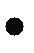

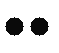

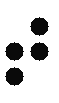

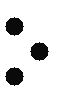

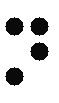

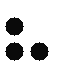

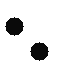

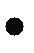

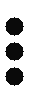

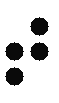

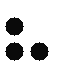

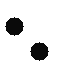

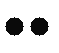

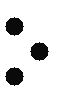

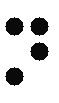

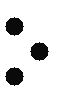

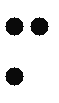

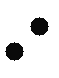

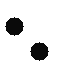

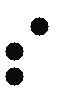

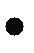

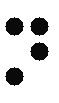

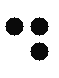

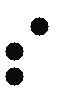

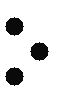

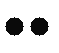

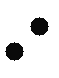

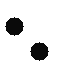

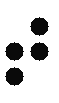

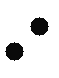

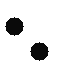

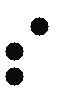

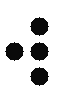

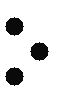

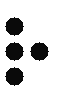

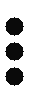

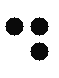

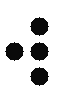

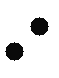

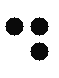

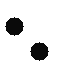

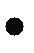

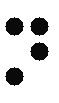

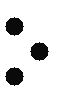

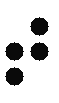

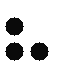

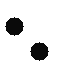

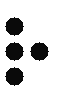

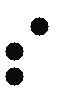

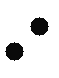

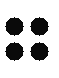

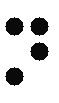

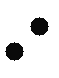

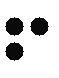

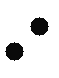

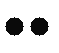

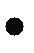

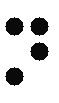

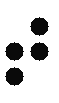

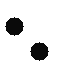

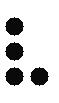

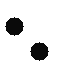

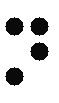

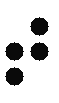

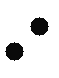

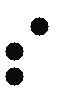

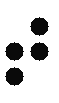

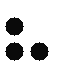

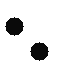

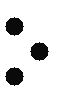

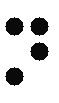

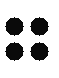

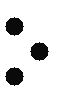

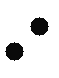

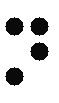

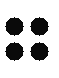

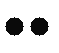

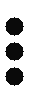

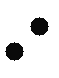

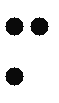

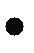

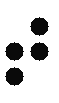

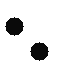

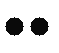

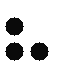

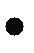

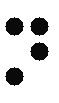

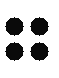

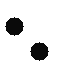

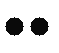

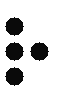

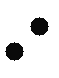

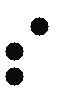

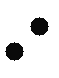

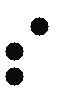

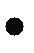

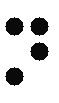

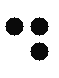

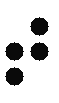

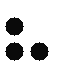

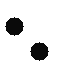

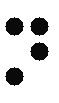

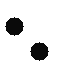

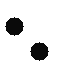

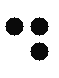

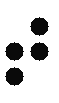

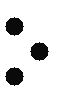

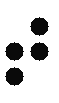

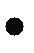

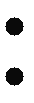

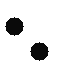

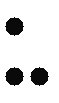

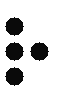

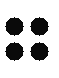

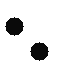

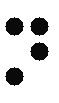

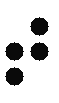

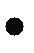

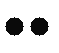

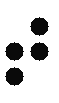

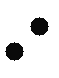

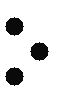

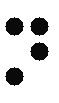

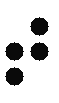

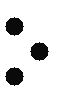

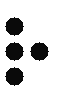

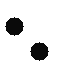

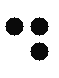

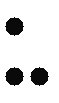

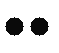

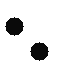

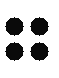

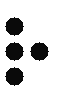

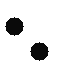

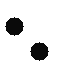

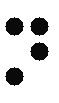

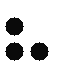

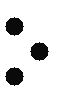

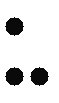

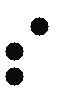

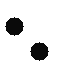

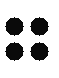

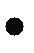

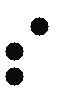

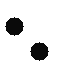

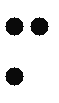

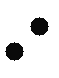

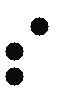

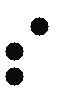

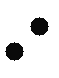

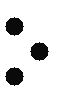

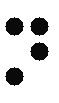

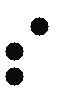

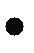

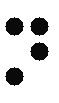

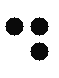

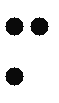

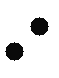

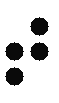

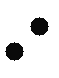

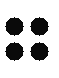

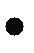

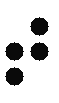

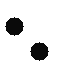

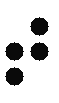

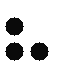

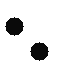

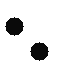

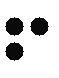

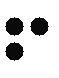

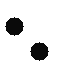

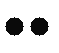

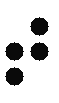

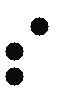

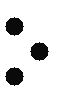

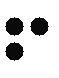

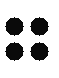

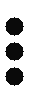

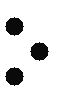

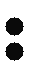

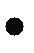

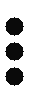

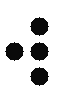

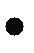

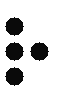

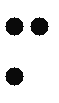

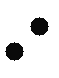

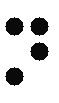

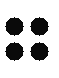

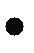

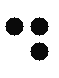

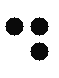

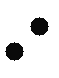

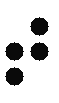

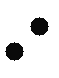

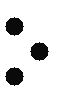

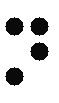

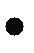

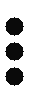

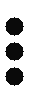

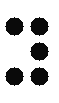

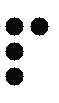

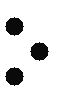

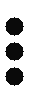

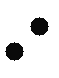

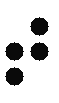

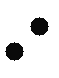

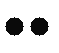

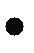

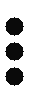

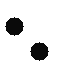

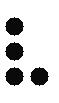

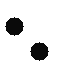

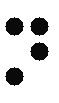

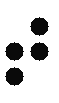

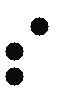

In [ ]:
braille_images = cropImage(labels_braille, braille, labels_braille_words, True) #get list of cropped images with spaces

In [ ]:
def matchImages(key, braille):
    characters = []

    for image1 in braille:
        if image1 == " ":
            characters.append(" ")
        else:
            #cv2.imshow("Braille Character", image1)
            #cv2.waitKey()
            differences = []

            for image2 in key:
                temp1 = copy.deepcopy(image1)
                temp2 = copy.deepcopy(image2)

                if image1.size > image2.size:   #decimate the bigger image
                    temp1 = cv2.resize(image1, dsize=(image2.shape[1], image2.shape[0]), interpolation=cv2.INTER_CUBIC)
                else:
                    temp2 = cv2.resize(image2, dsize=(image1.shape[1], image1.shape[0]), interpolation=cv2.INTER_CUBIC)

                differences.append(mse(temp1, temp2))   #create an array of mean squared errors

            #cv2.imshow("Key Match", key[differences.index(min(differences))])
            #cv2.waitKey()
            characters.append(chr(differences.index(min(differences)) + 97))    #get index of matching image in key and add 97 to create ascii value of equivalent english character

    return "".join(characters)

def mse(imageA, imageB):    #mean squared errors
    err = np.sum((imageA.astype("float") - imageB.astype("float")) ** 2)
    err /= float(imageA.shape[0] * imageA.shape[1])
    return err

In [ ]:
english_text = matchImages(decode_key, braille_images)  #check images for similarity and get equivalent character
print(english_text)

<ipython-input-60-06face7ccb48>:5: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if image1 == " ":


current affairs refer to events and incidents that are happening in the present time and have an impact on society politics the economy or other aspects of our daily lives there are always numerous ongoing events around the world that fall under this category some of the major current affairs topics that have dominated headlines in recent times include the covid pandemic and its impact on health economies and societies worldwide another significant event is the ongoing climate change crisis and the need to take urgent action to reduce greenhouse gas emissions and mitigate the effects of global warming additionally political events 
